In [14]:
import numpy as np
import torch
from transformers import *
from sklearn.mixture import GaussianMixture
import time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [15]:
train_embeddings = {}
test_embeddings = {}
sents = np.load('sentences.npy')
vectors = np.load('vectors.npy')
domain = np.load('domain.npy')
sentiment = np.load('sentiment.npy')

split = int(0.8 * len(sents))
train_embeddings['sents'] = sents[:split]
train_embeddings['vectors'] = vectors[:split]
train_embeddings['domain'] = domain[:split]
train_embeddings['sentiment'] = sentiment[:split]
test_embeddings['sents'] = sents[split:]
test_embeddings['vectors'] = vectors[split:]
test_embeddings['domain'] = domain[split:]
test_embeddings['sentiment'] = sentiment[split:]

In [29]:
DOMAINS = ['Automotive', 'Books', 'Music', 'Software', 'Baby']
N_CLUSTERS = 5

def GMM(data, num_clusters):
    model = GaussianMixture(
        n_components=num_clusters, 
        covariance_type='full', 
        max_iter=100, 
        random_state=0,
        verbose=1)

    model.fit(data)
    return model


def get_predictions(model, test_data):
    return model.predict(test_data)


def assign_labels_to_clusters(true_labels, predictions, num_clusters=8):
    cluster_assignment = {}
    true_count = 0
    total = 0
    for k in range(num_clusters):
        count = [0] * len(DOMAINS)
        for i, pred in enumerate(predictions):
            if pred == k:
                count[DOMAINS.index(true_labels[i])] += 1
        max_count = max(count)
        total_count = sum(count)
        cluster_assignment[k] = (DOMAINS[count.index(max_count)], max_count, total_count)
        true_count += max_count
        total += total_count
    acc = true_count / total
    return cluster_assignment, acc


def calc_test_accuracy(true_labels, predictions, cluster_assignment):
    total = 0
    true_count = 0
    for i, pred in enumerate(predictions):
        if cluster_assignment[pred][0] == true_labels[i]:
            true_count +=1
        total += 1
    return true_count / total

In [30]:
start = time.time()
model = GMM(train_embeddings['vectors'], N_CLUSTERS)
end  = time.time()
print(f"Time taken to converge: {(end-start) / 3600} hrs.")

Initialization 0
  Iteration 10
Initialization converged: True
Time taken to converge: 0.029642200734880237 hrs.


In [31]:
train_pred = get_predictions(model, train_embeddings['vectors'])
cluster_assignment, accuracy = assign_labels_to_clusters(train_embeddings['domain'], train_pred, N_CLUSTERS)
print(f"Train accuracy is {accuracy:.4f}")

test_pred = get_predictions(model, test_embeddings['vectors'])
test_accuracy = calc_test_accuracy(test_embeddings['domain'], test_pred, cluster_assignment)
print(f"Test accuracy is {test_accuracy:.4f}")

np.save('test_pred_gmm_k5_distilBERT.npy', test_pred)

Train accuracy is 0.7336
Test accuracy is 0.7345


In [32]:
for k in range(N_CLUSTERS):
    print(f'Cluster-{k+1} | label: {cluster_assignment[k][0]} | Purity: {cluster_assignment[k][1]/cluster_assignment[k][2]}')

Cluster-1 | label: Books | Purity: 0.8783880171184023
Cluster-2 | label: Baby | Purity: 0.5038820897486511
Cluster-3 | label: Software | Purity: 0.8186385931331499
Cluster-4 | label: Music | Purity: 0.9583933010597933
Cluster-5 | label: Books | Purity: 0.32989690721649484


In [33]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

tsne = TSNE(n_components=2, verbose=1, random_state=1)
z = tsne.fit_transform(test_embeddings['vectors'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...


/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 10000 samples in 2.374s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.795489
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.616364
[t-SNE] KL divergence after 1000 iterations: 2.670528


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

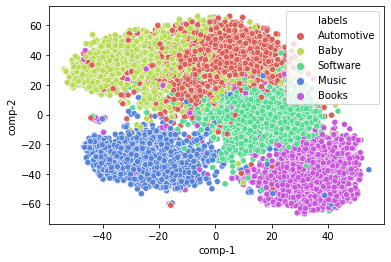

In [34]:
df = pd.DataFrame()
df["labels"] = test_embeddings['domain']
df["clusters"] = [cluster_assignment[pred][0] for pred in test_pred]
# df["clusters"] = test_pred
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="labels", palette=sns.color_palette("hls", 5))

/opt/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

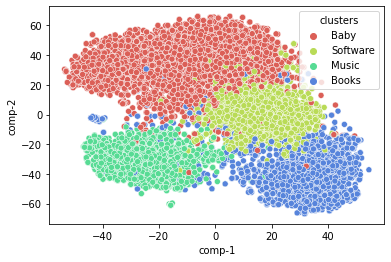

In [35]:
sns.scatterplot(data=df, x="comp-1", y="comp-2", hue="clusters", palette=sns.color_palette("hls", 5))